### Dependencies

In [1]:
import os
import cv2
import glob
import json
import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from skimage.draw import polygon
from scipy.spatial import Delaunay

# Project 3 - Face Morphing

## Part 1. Defining Correspondences

In [2]:
face_a = plt.imread('../data/filip.jpg')
face_b = plt.imread('../data/emelie.jpg')

# the points are defined in a json file called filip_emelie.json
with open('../data/filip_emelie.json', 'r') as f:
    points = json.load(f)

im1_points = np.array(points["im1Points"])
im2_points = np.array(points["im2Points"])

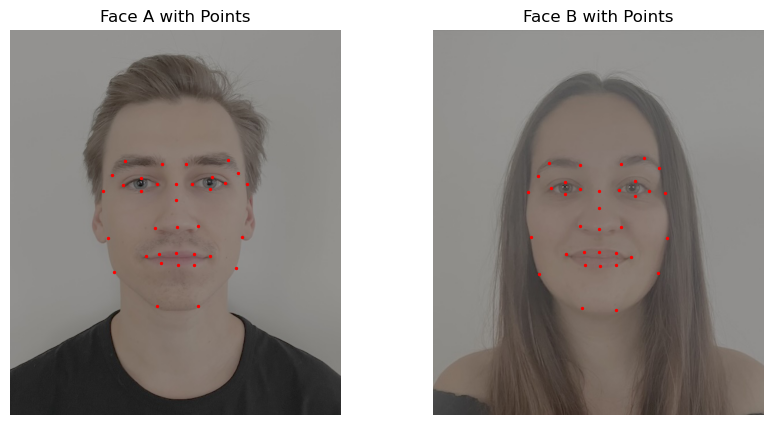

In [3]:
# Plot image
def plot_points_on_face(image, points, ax):    
    ax.imshow(image)
    ax.scatter(points[:, 0], points[:, 1], color='red', marker='o', s=2)
    ax.axis('off')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot points on face_a
plot_points_on_face(face_a, im1_points, axes[0])
axes[0].set_title('Face A with Points')

# Plot points on face_b
plot_points_on_face(face_b, im2_points, axes[1])
axes[1].set_title('Face B with Points')

plt.show()

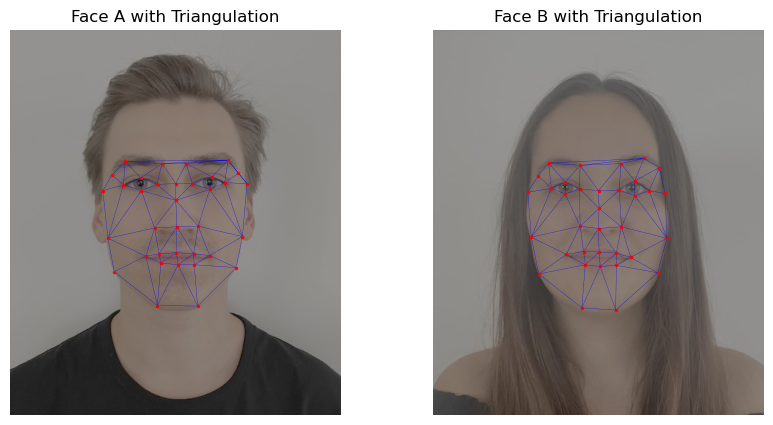

In [4]:
def plot_points_with_triangulation(image, points, ax):    
    # Create a Delaunay triangulation from the points
    delaunay_triangulation = tri.Triangulation(points[:, 0], points[:, 1])
    ax.imshow(image)
    
    # Plot the triangulation lines
    ax.triplot(delaunay_triangulation, color='blue', linewidth=0.2)
    
    # Plot the points
    ax.scatter(points[:, 0], points[:, 1], color='red', marker='o', s=2)
    
    # Remove axis
    ax.axis('off')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot points and triangulation for both face_a and face_b
plot_points_with_triangulation(face_a, im1_points, axes[0])
axes[0].set_title('Face A with Triangulation')

plot_points_with_triangulation(face_b, im2_points, axes[1])
axes[1].set_title('Face B with Triangulation')

plt.show()

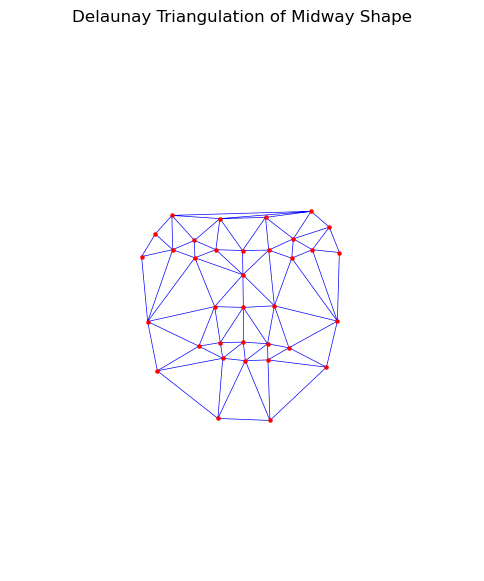

In [5]:
# Compute the midway shape points
midway_points = (im1_points + im2_points) / 2

# Perform Delaunay triangulation on the midway points
tri = Delaunay(midway_points)

# Visualize the triangulation on the midway shape
plt.figure(figsize=(6, 8)) 
plt.triplot(midway_points[:, 0], midway_points[:, 1], tri.simplices, color='blue', linewidth=0.5)
plt.scatter(midway_points[:, 0], midway_points[:, 1], color='red', marker='o', s=5)

# Set the aspect ratio to match the image dimensions
plt.gca().set_aspect('equal', adjustable='box')

# Set axis limits to match image size (width x height = 576 x 670)
plt.xlim(0, 576)
plt.ylim(670, 0)  # Invert Y-axis to match image coordinates

# Display the plot
plt.title("Delaunay Triangulation of Midway Shape")
plt.axis('off')
plt.show()

## Part 2. Computing the "Mid-way Face"

In [6]:
def compute_affine(tri1_pts, tri2_pts):
    # Create matrices for triangle points
    tri1 = np.vstack((tri1_pts.T, np.ones((1, 3))))
    tri2 = np.vstack((tri2_pts.T, np.ones((1, 3))))
    
    # Compute the affine transformation matrix A
    A = np.dot(tri2, np.linalg.inv(tri1))
    
    return A

def warp_triangle(img, src_tri, dst_tri, dst_shape):
    A = compute_affine(src_tri, dst_tri)
    
    rr, cc = polygon(dst_tri[:, 1], dst_tri[:, 0], shape=dst_shape)
    
    # Apply inverse warp to find the corresponding pixel in the source image
    coords = np.vstack((cc, rr, np.ones(len(rr))))
    warped_coords = np.dot(np.linalg.inv(A), coords)
    
    # Interpolation to find pixel values in the source image
    x_warped = np.clip(warped_coords[0].astype(int), 0, img.shape[1]-1)
    y_warped = np.clip(warped_coords[1].astype(int), 0, img.shape[0]-1)
    
    # Warp pixels from the source image
    warped_img = np.zeros_like(img)
    warped_img[rr, cc] = img[y_warped, x_warped]
    
    return warped_img

def compute_midway_face(img_a, img_b, points_a, points_b, triangles):
    # Compute the average shape
    avg_points = (points_a + points_b) / 2
    
    warped_a = np.zeros_like(img_a)
    warped_b = np.zeros_like(img_b)
    
    mask_a = np.zeros((img_a.shape[0], img_a.shape[1]), dtype=np.uint8)
    mask_b = np.zeros((img_b.shape[0], img_b.shape[1]), dtype=np.uint8)
    
    for tri_indices in triangles.simplices:
        # Get the points of the triangles in both images and the average
        tri_a = points_a[tri_indices]
        tri_b = points_b[tri_indices]
        tri_avg = avg_points[tri_indices]
        
        # Warp the triangles in both images to the average shape
        warped_a += warp_triangle(img_a, tri_a, tri_avg, img_a.shape)
        warped_b += warp_triangle(img_b, tri_b, tri_avg, img_b.shape)
        
        # Fill the masks with 1s where the triangles are placed
        rr, cc = polygon(tri_avg[:, 1], tri_avg[:, 0], shape=img_a.shape)
        mask_a[rr, cc] = 1
        mask_b[rr, cc] = 1
    
    # Average the colors of the warped images inside the face region
    midway_face = (warped_a / 2 + warped_b / 2).astype(np.uint8)
    
    # Handle the background by averaging the regions outside the triangles
    mask_combined = np.maximum(mask_a, mask_b)
    background_a = img_a * (1 - mask_combined[..., np.newaxis])
    background_b = img_b * (1 - mask_combined[..., np.newaxis])
    
    # Average the background areas and add them to the warped image
    background_avg = (background_a / 2 + background_b / 2).astype(np.uint8)
    final_image = midway_face + background_avg
    
    return final_image

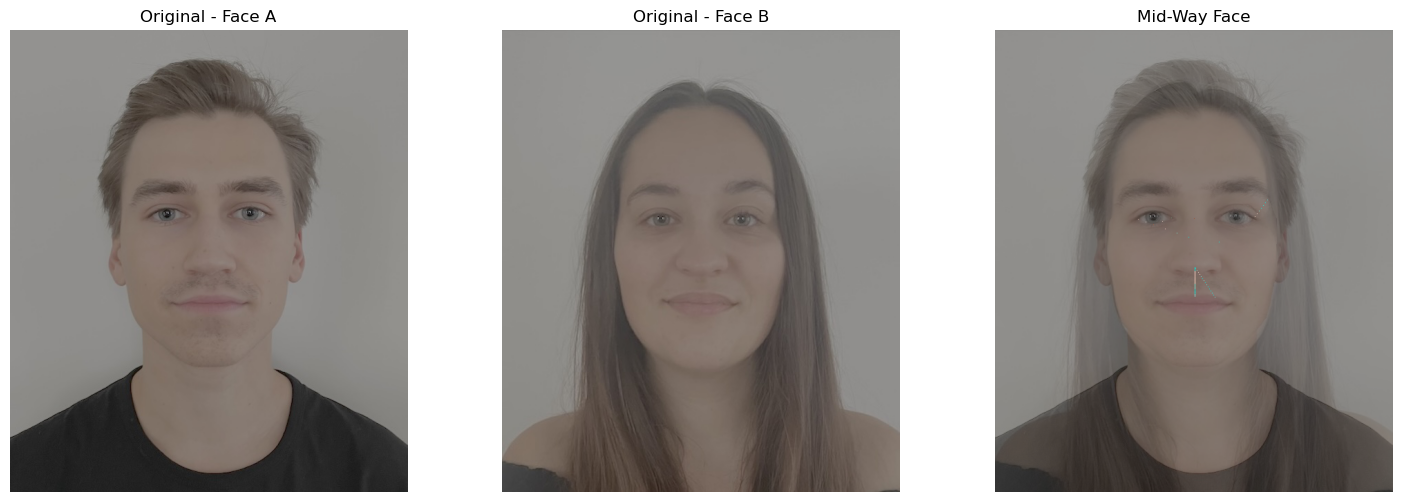

In [7]:
# Compute the Delaunay triangulation of the average points
average_points = (im1_points + im2_points) / 2
tri = Delaunay(average_points)

# Compute the mid-way face
midway_face = compute_midway_face(face_a, face_b, im1_points, im2_points, tri)

# Display the original and mid-way face
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(face_a)
plt.axis('off')
plt.title("Original - Face A")

plt.subplot(1, 3, 2)
plt.imshow(face_b)
plt.axis('off')
plt.title("Original - Face B")

plt.subplot(1, 3, 3)
plt.imshow(midway_face)
plt.axis('off')
plt.title("Mid-Way Face")

plt.show()

## Part 3. The Morph Sequence

In [8]:
def warp_triangle(src, src_tri, dst_tri, dst_shape):
    src_rect = cv2.boundingRect(np.float32([src_tri]))
    dst_rect = cv2.boundingRect(np.float32([dst_tri]))
    
    src_tri_offset = []
    dst_tri_offset = []
    
    for i in range(3):
        src_tri_offset.append(((src_tri[i][0] - src_rect[0]), (src_tri[i][1] - src_rect[1])))
        dst_tri_offset.append(((dst_tri[i][0] - dst_rect[0]), (dst_tri[i][1] - dst_rect[1])))
    
    src_img_cropped = src[src_rect[1]:src_rect[1]+src_rect[3], src_rect[0]:src_rect[0]+src_rect[2]]
    
    # Warp the cropped source image to the destination triangle
    warp_mat = cv2.getAffineTransform(np.float32(src_tri_offset), np.float32(dst_tri_offset))
    warped_triangle = cv2.warpAffine(src_img_cropped, warp_mat, (dst_rect[2], dst_rect[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    # Create a mask for the destination triangle
    mask = np.zeros((dst_rect[3], dst_rect[2]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_tri_offset), 1, 16, 0)
    
    # Prepare the destination part (same size as the destination image)
    dest_img_part = np.zeros((dst_shape[0], dst_shape[1], dst_shape[2]), dtype=src.dtype)
    
    # Use only the triangular area of the warped image
    dest_img_part[dst_rect[1]:dst_rect[1]+dst_rect[3], dst_rect[0]:dst_rect[0]+dst_rect[2]] = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask)
    
    return dest_img_part


def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    # Compute intermediate shape points based on warp_frac
    intermediate_pts = (1 - warp_frac) * im1_pts + warp_frac * im2_pts
    
    # Initialize warped images for im1 and im2
    warped_im1 = np.zeros_like(im1)
    warped_im2 = np.zeros_like(im2)
    mask_im1 = np.zeros((im1.shape[0], im1.shape[1]), dtype=np.float32)
    mask_im2 = np.zeros((im2.shape[0], im2.shape[1]), dtype=np.float32)
    
    # Warp triangles of both images into the intermediate shape
    for tri_indices in tri.simplices:
        # Get triangle vertices from both images and intermediate shape
        tri_im1 = im1_pts[tri_indices]
        tri_im2 = im2_pts[tri_indices]
        tri_intermediate = intermediate_pts[tri_indices]
        
        # Warp im1 and im2 to the intermediate shape
        warped_triangle_im1 = warp_triangle(im1, tri_im1, tri_intermediate, im1.shape)
        warped_triangle_im2 = warp_triangle(im2, tri_im2, tri_intermediate, im2.shape)
        
        # Create masks for the warped triangles
        mask_triangle_im1 = np.zeros((im1.shape[0], im1.shape[1]), dtype=np.float32)
        mask_triangle_im2 = np.zeros((im2.shape[0], im2.shape[1]), dtype=np.float32)
        
        cv2.fillConvexPoly(mask_triangle_im1, np.int32(tri_intermediate), 1, 16, 0)
        cv2.fillConvexPoly(mask_triangle_im2, np.int32(tri_intermediate), 1, 16, 0)
        
        # Alpha blend the warped triangles into the warped images
        for c in range(3):
            warped_im1[:, :, c] = warped_im1[:, :, c] * (1 - mask_triangle_im1) + warped_triangle_im1[:, :, c] * mask_triangle_im1
            warped_im2[:, :, c] = warped_im2[:, :, c] * (1 - mask_triangle_im2) + warped_triangle_im2[:, :, c] * mask_triangle_im2
        
        mask_im1 += mask_triangle_im1
        mask_im2 += mask_triangle_im2
    
    # Normalize the masks
    mask_im1 = np.clip(mask_im1, 0, 1)
    mask_im2 = np.clip(mask_im2, 0, 1)
    
    # Cross dissolve the warped images using dissolve_frac
    morphed_im = (1 - dissolve_frac) * warped_im1 + dissolve_frac * warped_im2

    # Blend the full images (not just the warped regions)
    morphed_im_full = (1 - dissolve_frac) * im1 + dissolve_frac * im2

    # Create a mask for the warped regions
    mask = np.any(warped_im1 > 0, axis=-1)

    # Only apply the morphed regions to the corresponding areas in the full image
    morphed_im_full[mask] = morphed_im[mask]

    return morphed_im_full.astype(np.uint8)

def create_morph_sequence(im1, im2, im1_pts, im2_pts, tri, num_frames, output_path):
    # Ensure that both images have the same shape
    assert im1.shape == im2.shape, "Images must have the same shape."
    
    # Video writer setup
    height, width, channels = im1.shape
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

    # Iterate through the number of frames
    for i in range(num_frames):
        # Calculate warp_frac and dissolve_frac for this frame
        warp_frac = i / (num_frames - 1)
        dissolve_frac = i / (num_frames - 1)
        
        # Compute the morphed image
        morphed_im = morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac)
        
        # Convert RGB to BGR for saving with OpenCV (OpenCV uses BGR by default)
        frame_bgr = cv2.cvtColor(morphed_im, cv2.COLOR_RGB2BGR)
        
        # Write the frame to the video
        video.write(frame_bgr)
    
    # Release the video writer
    video.release()

    print(f"Morphing video saved at {output_path}")

# Example call to create the morph sequence
create_morph_sequence(face_a, face_b, im1_points, im2_points, tri, num_frames=30, output_path="morph_sequence.mp4")

Morphing video saved at morph_sequence.mp4


## Part 4. The "Mean face" of a population

In [9]:
import os
import glob
import cv2
import numpy as np

def load_images_and_landmarks(path, gender, expression):
    images = []
    landmarks = []
    
    # Construct the file pattern based on gender and expression
    file_pattern = f"*-{expression}{gender}.jpg"
    image_files = glob.glob(os.path.join(path, file_pattern))
    
    for img_file in image_files:
        # Load the image
        img = cv2.imread(img_file)
        if img is None:
            print(f"Warning: {img_file} could not be read. Skipping this file.")
            continue
        images.append(img)
        
        # Load the corresponding .asf file
        asf_file = img_file.replace('.jpg', '.asf')
        points = []

        with open(asf_file, 'r') as f:
            lines = f.readlines()
            num_points_found = False
            for line in lines:
                if line.strip().startswith('#'):
                    continue
                if line.strip() == "58":  # Look for the number of points
                    num_points_found = True
                    continue
                if num_points_found:
                    parts = line.split()
                    if len(parts) >= 7:
                        x, y = float(parts[2]), float(parts[3])
                        points.append((x, y))

        if len(points) == 58:
            landmarks.append(np.array(points))
        else:
            print(f"Warning: {asf_file} has {len(points)} landmarks instead of 58. Skipping this file.")
        
    return images, landmarks

# Example usage
path = '../data/imm_face_db/'
images, male_neutral_landmarks = load_images_and_landmarks(path, "m", 1)
print(f'Loaded {len(images)} images and their corresponding landmarks.')

Loaded 33 images and their corresponding landmarks.


In [10]:
def normalize_landmarks(landmarks, img_shape):
    height, width = img_shape[:2]
    normalized = [(x * width, y * height) for x, y in landmarks]
    return np.array(normalized)

# Normalize landmarks for each image
normalized_landmarks = [normalize_landmarks(landmark, img.shape) for landmark, img in zip(male_neutral_landmarks, images)]

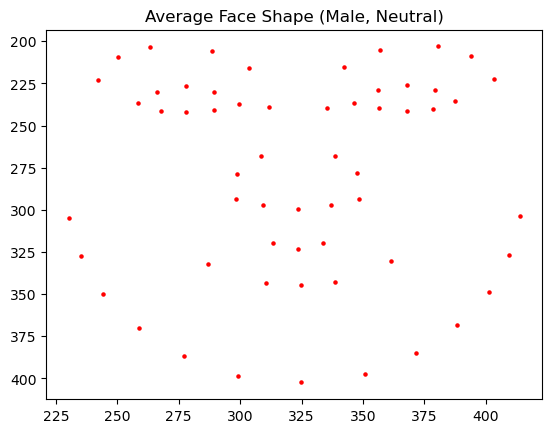

In [11]:
def compute_average_shape(landmarks):
    # Stack all landmark points into an array
    stacked_landmarks = np.array(landmarks)
    # Compute the mean along the first axis to get the average shape
    avg_shape = np.mean(stacked_landmarks, axis=0)
    return avg_shape

average_landmark = compute_average_shape(normalized_landmarks)

# Plot the average landmark points to visualize
plt.scatter(average_landmark[:, 0], average_landmark[:, 1], color='red', s=5)
plt.title('Average Face Shape (Male, Neutral)')
plt.gca().invert_yaxis()  # Invert Y axis for proper image alignment
plt.show()

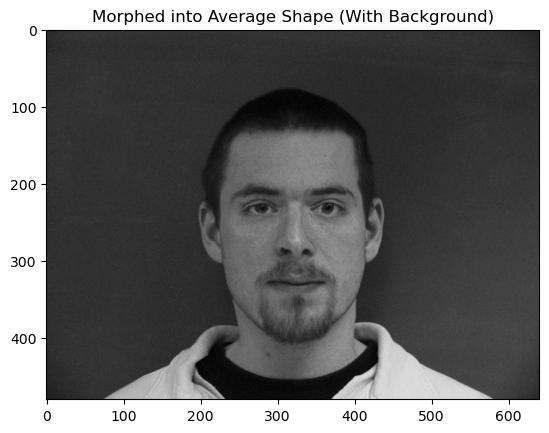

In [12]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

def add_boundary_points(landmarks, img_shape):
    """Add image corners to the landmarks to include the background."""
    height, width = img_shape[:2]
    boundary_points = [(0, 0), (width - 1, 0), (width - 1, height - 1), (0, height - 1)]
    return np.vstack([landmarks, boundary_points])

# Add boundary points to both the normalized landmarks and the average landmarks
extended_landmarks = [add_boundary_points(landmark, img.shape) for landmark, img in zip(normalized_landmarks, images)]
extended_average_landmark = add_boundary_points(average_landmark, images[0].shape)

def delaunay_triangulation(points):
    return Delaunay(points)

def affine_transform(src, dst, img, size):
    # Calculate the affine transformation matrix
    warp_matrix = cv2.getAffineTransform(np.float32(src), np.float32(dst))
    # Warp the image using the affine transformation matrix
    warped = cv2.warpAffine(img, warp_matrix, (size[1], size[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return warped

def morph_to_average_shape(img, landmarks, average_shape, img_shape):
    # Add boundary points to landmarks and average shape
    extended_landmarks = add_boundary_points(landmarks, img_shape)
    extended_avg_shape = add_boundary_points(average_shape, img_shape)
    
    # Compute Delaunay triangulation for the average shape with boundary points
    tri = delaunay_triangulation(extended_avg_shape)
    
    # Create an empty canvas for the warped image
    morphed_img = np.zeros(img_shape, dtype=img.dtype)
    
    # Warp each triangle from the original face to the average face
    for simplex in tri.simplices:
        # Get the points for each triangle in the original face
        src_triangle = extended_landmarks[simplex]
        # Get the points for each triangle in the average shape
        dst_triangle = extended_avg_shape[simplex]
        
        # Perform affine transformation
        warped_triangle = affine_transform(src_triangle, dst_triangle, img, img_shape)
        
        # Create a mask for the triangle and add it to the morphed image
        mask = np.zeros(img_shape[:2], dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dst_triangle), 255)
        morphed_img[mask > 0] = warped_triangle[mask > 0]
    
    return morphed_img

# Morph each face with the background into the average shape
morphed_images = [morph_to_average_shape(img, landmark, average_landmark, img.shape) for img, landmark in zip(images, normalized_landmarks)]

# Display an example morphed image with the background
plt.imshow(morphed_images[0])
plt.title("Morphed into Average Shape (With Background)")
plt.show()

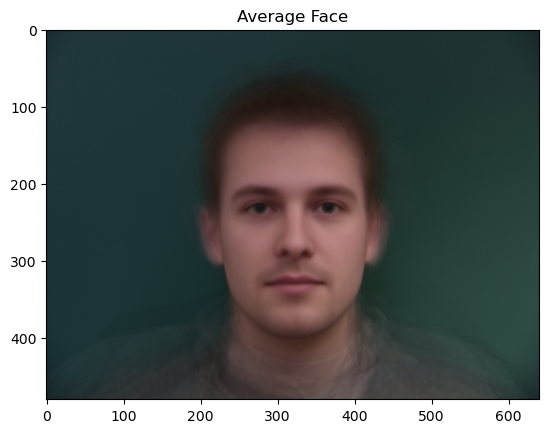

In [13]:
def compute_average_face(morphed_images):
    # Stack the morphed images and compute the mean along the first axis
    avg_face = np.mean(np.array(morphed_images), axis=0).astype(np.uint8)
    return avg_face

# Compute the average face with background
average_face = compute_average_face(morphed_images)

# Display the average face with background
plt.imshow(cv2.cvtColor(average_face, cv2.COLOR_BGR2RGB))
plt.title("Average Face")
plt.show()

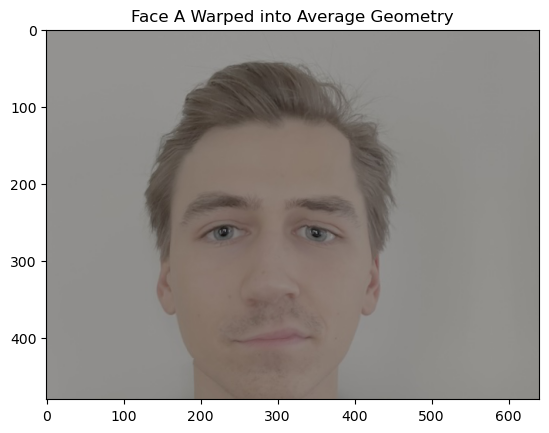

In [14]:
# Warp the first face to the average geometry
face_to_avg = morph_to_average_shape(face_a, normalized_landmarks[0], average_landmark, images[0].shape)

# Display the result
plt.imshow(face_to_avg)
plt.title("Face A Warped into Average Geometry")
plt.show()

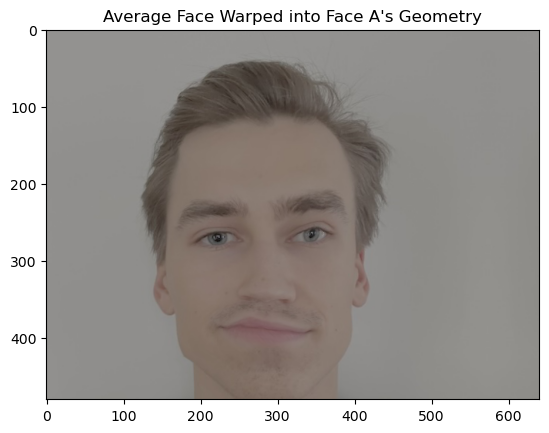

In [15]:
# Warp the average face to the geometry of face A
avg_to_face_a = morph_to_average_shape(face_a, average_landmark, normalized_landmarks[0], images[0].shape)

# Display the result
plt.imshow(avg_to_face_a)
plt.title("Average Face Warped into Face A's Geometry")
plt.show()

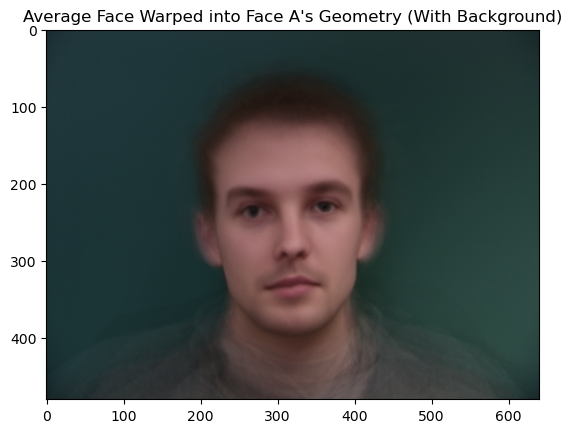

In [16]:
# Warp the average face into the geometry of face_a (first image)
def warp_average_to_face(img, img_landmarks, average_landmarks, img_shape):
    return morph_to_average_shape(img, average_landmarks, img_landmarks, img_shape)

# Warp the average face into face_a's geometry
average_face_to_face_a_geometry = warp_average_to_face(average_face, normalized_landmarks[0], average_landmark, images[0].shape)

# Display the result
plt.imshow(cv2.cvtColor(average_face_to_face_a_geometry, cv2.COLOR_BGR2RGB))
plt.title("Average Face Warped into Face A's Geometry (With Background)")
plt.show()

## Part 5. Caricatures: Extrapolating from the mean

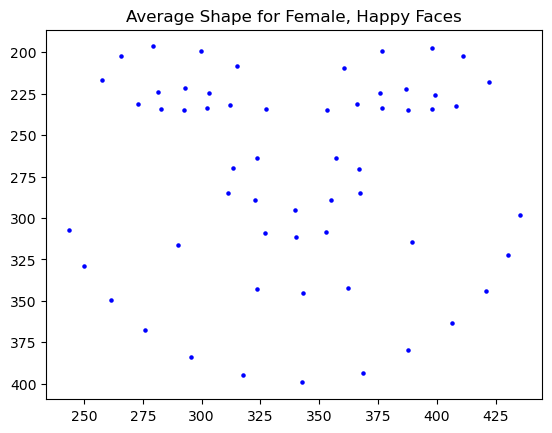

In [17]:
# Load female, happy images and compute their average shape
path = '../data/imm_face_db/'
female_happy_images, female_happy_landmarks = load_images_and_landmarks(path, "f", 2)

# Normalize landmarks
female_happy_normalized_landmarks = [normalize_landmarks(l, img.shape) for l, img in zip(female_happy_landmarks, female_happy_images)]

# Compute the average shape for female, happy faces
average_female_happy_landmark = compute_average_shape(female_happy_normalized_landmarks)

# Display the average shape of female happy faces
plt.scatter(average_female_happy_landmark[:, 0], average_female_happy_landmark[:, 1], color='blue', s=5)
plt.title('Average Shape for Female, Happy Faces')
plt.gca().invert_yaxis()
plt.show()

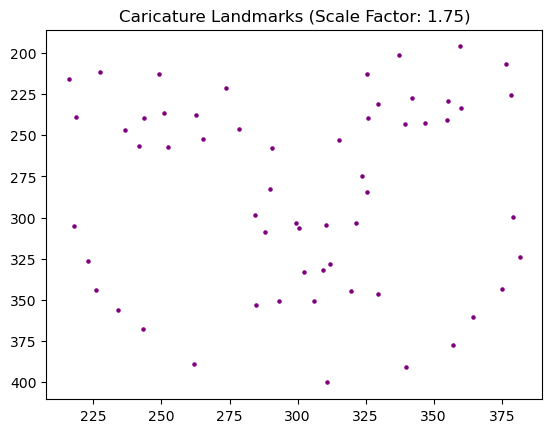

In [18]:
# Function to create caricature using the weighted average formula
def create_caricature_using_weighted_average(face_landmarks, avg_landmarks, scale=1.75):
    # Caricature formula: caricature = scale * me + (1 - scale) * avg
    caricature_landmarks = scale * face_landmarks + (1 - scale) * avg_landmarks
    return caricature_landmarks

# Use face_a's normalized landmarks and the average shape for female, happy faces
scale_factor = 1.75  # Exaggeration factor
caricature_landmarks = create_caricature_using_weighted_average(normalized_landmarks[0], average_female_happy_landmark, scale_factor)

# Plot the exaggerated landmarks for the caricature
plt.scatter(caricature_landmarks[:, 0], caricature_landmarks[:, 1], color='purple', s=5)
plt.title(f'Caricature Landmarks (Scale Factor: {scale_factor})')
plt.gca().invert_yaxis()
plt.show()

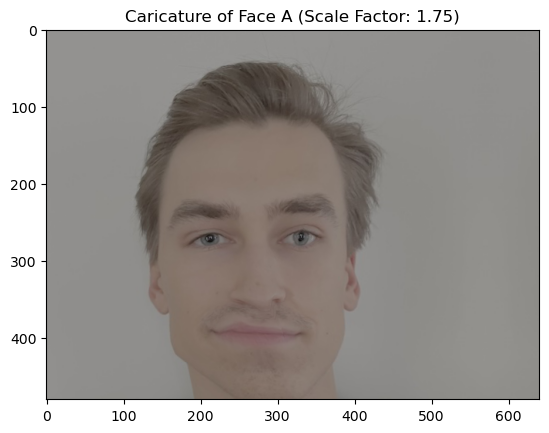

In [19]:
# Adjust the warp_face_to_caricature function to match the correct number of arguments
def warp_face_to_caricature(img, face_landmarks, caricature_landmarks, img_shape):
    return morph_to_average_shape(img, face_landmarks, caricature_landmarks, img_shape)

# Perform the warping for the caricature using corrected function call
caricature_image = warp_face_to_caricature(face_a, normalized_landmarks[0], caricature_landmarks, images[0].shape)

# Display the caricature image
plt.imshow(caricature_image)
plt.title(f'Caricature of Face A (Scale Factor: {scale_factor})')
plt.show()